In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import os

In [1]:
from tsai.all import *
import sklearn.metrics as skm
my_setup()

os              : Windows-10-10.0.19045-SP0
python          : 3.9.16
tsai            : 0.3.9
fastai          : 2.7.15
fastcore        : 1.5.54
torch           : 2.0.1
device          : 1 gpu (['NVIDIA GeForce GTX 1050 Ti'])
cpu cores       : 4
threads per cpu : 2
RAM             : 7.88 GB
GPU memory      : [4.0] GB


In [3]:
# 导入数据集
X = np.load('./dataset1/X_train.npy')
Y = pd.read_csv('./dataset1/Y_train.csv')
X_val = np.load('./dataset1/X_test.npy')

epoch,train_loss,valid_loss,accuracy,time
0,1.331264,1.272504,0.520398,16:05
1,1.349294,1.313879,0.510682,16:23
2,1.579552,1.637345,0.399943,15:57
3,2.312967,2.413749,0.126847,16:12
4,2.606604,2.407318,0.095426,15:21
5,2.398987,2.470713,0.113750,15:08
6,2.178702,2.610407,0.169943,15:37
7,2.197135,2.560525,0.134574,16:02
8,1.751564,1.886685,0.303523,16:03
9,1.559361,1.720956,0.362500,16:20


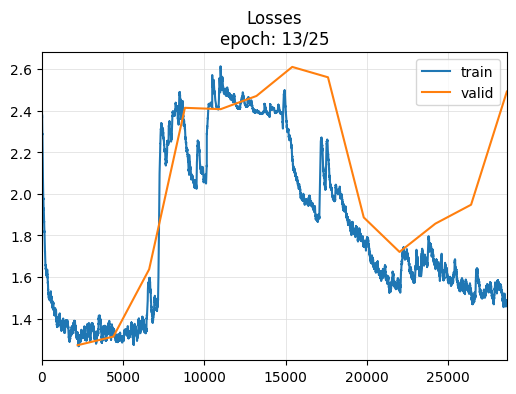

KeyboardInterrupt: 

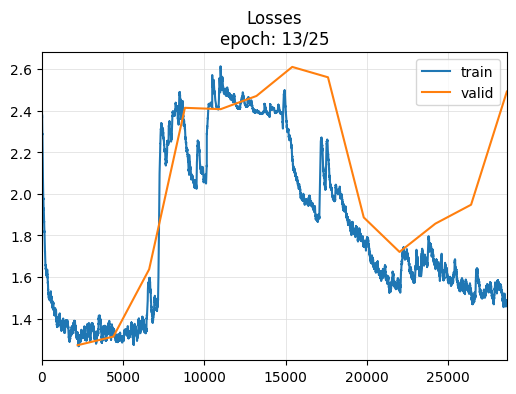

In [5]:
# # 运用K折交叉验证
kflod = KFold(n_splits=5, shuffle=True, random_state=0)

class_nums = 11

# 遍历K折交叉验证
for fold_num, (train_index, test_index) in enumerate(kflod.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y['Label'][train_index]-1, Y['Label'][test_index]-1
    y_train, y_test = y_train.values, y_test.values

    # train_ds = TSDataset(X_train, y_train, types=(TSTensor, TSLabelTensor))
    # train_dl = DataLoader(train_ds, bs=64, num_workers=3)
    # valid_ds = TSDataset(X_test, y_test, types=(TSTensor, TSLabelTensor))
    # valid_dl = DataLoader(valid_ds, bs=128, num_workers=2)
    # dls = DataLoaders(train_dl, valid_dl, device=default_device())
    ts_X, ts_y, ts_splits = combine_split_data([X_train, X_test], [y_train, y_test])
    tfms = [None, [Categorize()]]
    dsets = TSDatasets(ts_X, ts_y, tfms=tfms, splits=ts_splits, inplace=True)
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 64], device=default_device(), batch_tfms=[TSStandardize()]) # 不能设置num_workers

    model = LSTMAttention(c_in=X_train.shape[-2], c_out=class_nums, seq_len=128)

    learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy, cbs=ShowGraph())
    # learn.lr_find()
    learn.fit_one_cycle(25, lr_max=5e-3)
    path = './question1-tsai-result/original/LSTMAttention/fold_{}'.format(fold_num)
    os.makedirs(path, exist_ok=True)
    learn.save_all(path=path, dls_fname='original', model_fname='LSTMAttention', learner_fname='learner')